In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import math
from scipy.stats import skew

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [66]:
PATH_TRAIN = r"..\datasets\train.csv"
PATH_TEST = r"..\datasets\test.csv"

In [67]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

In [68]:
print("Shape Train:", df_train.shape)
print("Shape Test:", df_test.shape)

Shape Train: (1460, 81)
Shape Test: (1459, 80)


In [69]:
DROPPED_COL = ["Id", "Utilities"]
X = df_train.drop(["SalePrice", *DROPPED_COL], axis=1)
y = df_train["SalePrice"]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin


class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, target_col):
        self.group_col = group_col
        self.target_col = target_col

    def fit(self, X, y=None):
        self.median_values = X.groupby(self.group_col)[
            self.target_col].median()
        self.global_median_ = X[self.target_col].median()
        return self

    def transform(self, X):
        df = X.copy()
        df[self.target_col] = df[self.target_col].fillna(
            df[self.group_col].map(self.median_values))
        df[self.target_col] = df[self.target_col].fillna(self.global_median_)
        return df

In [71]:
ORDINAL_MAPS = [
    {
        "columns": [
            "ExterQual",
            "ExterCond",
            "BsmtQual",
            "BsmtCond",
            "HeatingQC",
            "KitchenQual",
            "FireplaceQu",
            "GarageQual",
            "GarageCond",
            "BsmtExposure",
            "PoolQC",
        ],
        "ordinalMap": {
            "Ex": 5,
            "Gd": 4,
            "TA": 3,
            "Fa": 2,
            "Po": 1,

            "Av": 3,
            "Mn": 2,
            "No": 1
        }
    },


    {
        "columns": [
            "BsmtFinType1",
            "BsmtFinType2"
        ],
        "ordinalMap": {
            "GLQ": 6,
            "ALQ": 5,
            "BLQ": 4,
            "Rec": 3,
            "LwQ": 2,
            "Unf": 1
        }
    },

    {
        "columns": [
            "Street",
            "Alley"
        ],
        "ordinalMap": {
            "Pave": 1,
            "Grvl": 0
        }
    },


    {
        "columns": [
            "Functional"
        ],
        "ordinalMap": {
            "Typ": 8,
            "Min1": 7,
            "Min2": 6,
            "Mod": 5,
            "Maj1": 4,
            "Maj2": 3,
            "Sev": 2,
            "Sal": 1
        }
    },

    {
        "columns": [
            "Electrical"
        ],
        "ordinalMap": {
            "SBrkr": 5,
            "FuseA": 4,
            "FuseF": 3,
            "Mix": 2,
            "FuseP": 1
        }
    },


    {
        "columns": [
            "LotShape"
        ],
        "ordinalMap": {
            "Reg": 4,
            "IR1": 3,
            "IR2": 2,
            "IR3": 1
        }
    },

    {
        "columns": [
            "LandContour"
        ],
        "ordinalMap": {
            "Lvl": 4,
            "Bnk": 3,
            "HLS": 2,
            "Low": 1
        }
    },

    {
        "columns": [
            "GarageFinish"
        ],
        "ordinalMap": {
            "Fin": 3,
            "RFn": 2,
            "Unf": 1
        }
    },


    {
        "columns": [
            "PavedDrive"
        ],
        "ordinalMap": {
            "Y": 2,
            "P": 1,
            "N": 0
        }
    },

    {
        "columns": [
            "CentralAir"
        ],
        "ordinalMap": {
            "Y": 1,
            "N": 0
        }
    },

    {
        "columns": [
            "LandSlope"
        ],
        "ordinalMap": {
            "Gtl": 3,
            "Mod": 2,
            "Sev": 1
        }
    },

    {
        "columns": [
            "Fence"
        ],
        "ordinalMap": {
            "GdPrv": 4,
            "MnPrv": 3,
            "GdWo": 2,
            "MnWw": 1
        }
    },

    # {
    #     "columns": [
    #         "Utilities"
    #     ],
    #     "ordinalMap": {
    #         "AllPub": 4,
    #         "NoSewr": 3,
    #         "NoSeWa": 2,
    #         "ELO": 1
    #     }
    # },

]


for item in ORDINAL_MAPS:
    X[item["columns"]] = X[item["columns"]].map(
        lambda x: item["ordinalMap"].get(x, x))

<Axes: >

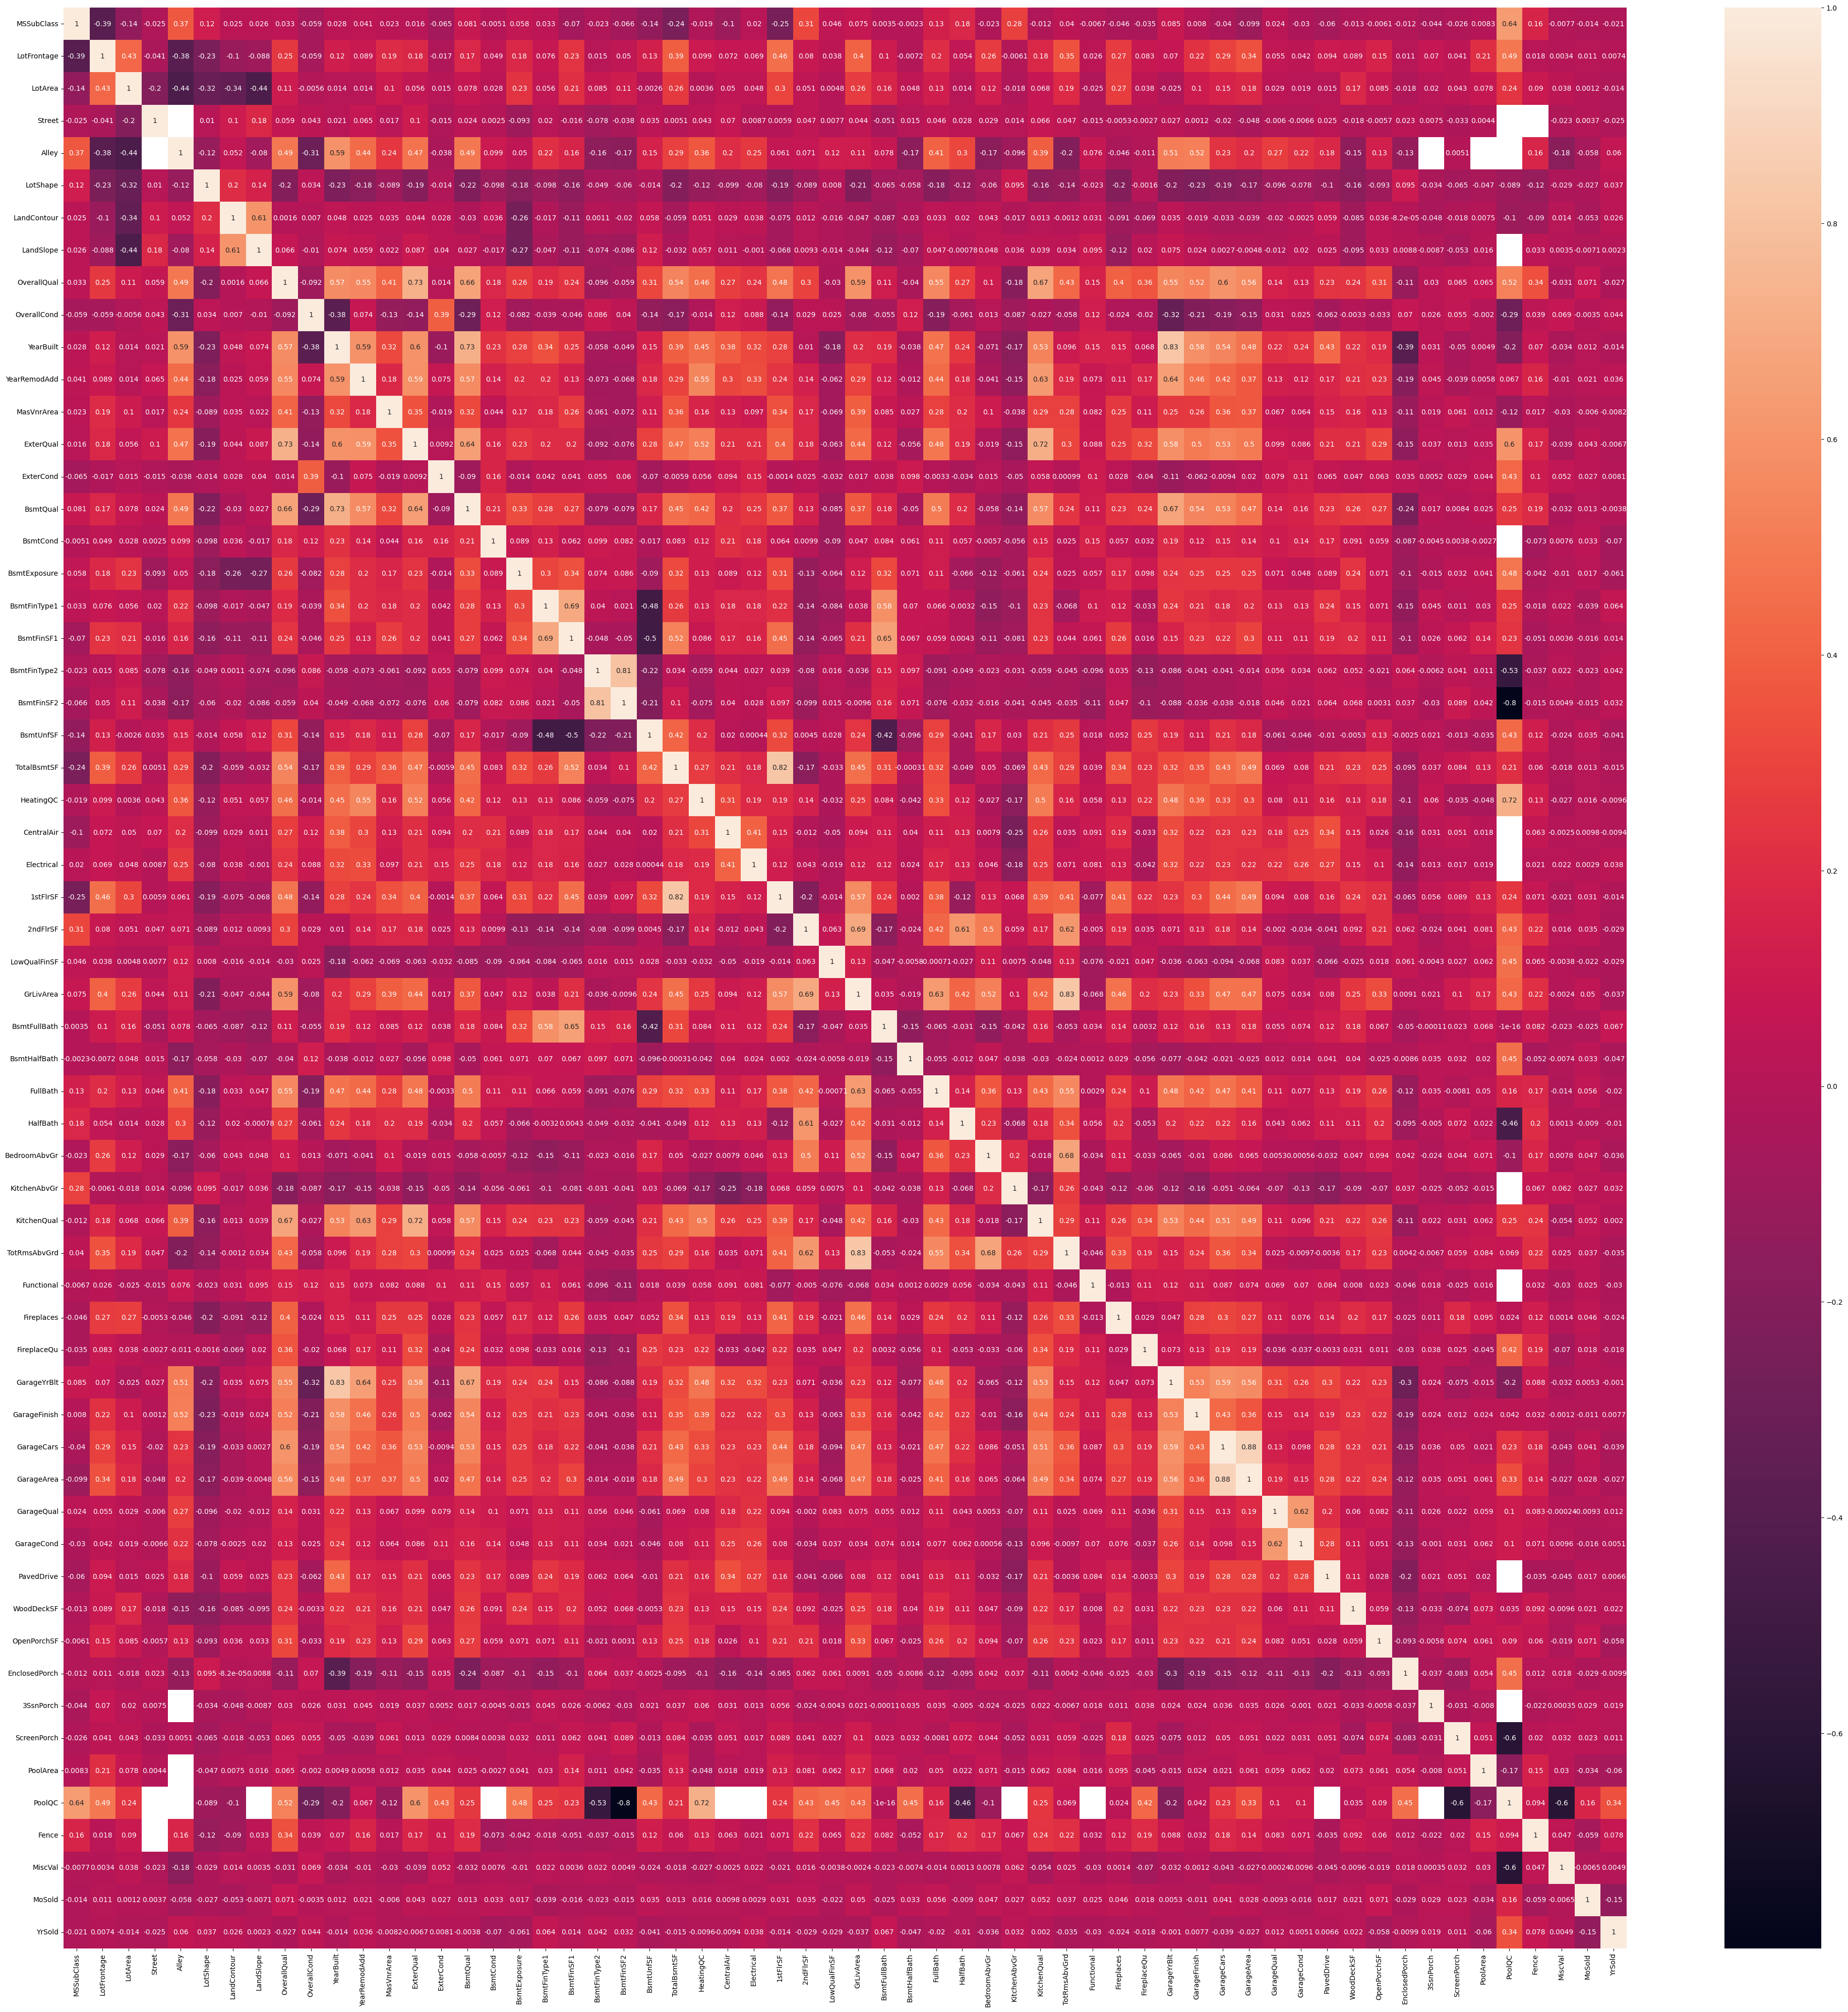

In [72]:
plt.figure(figsize=(50, 50))
sns.heatmap(X.corr(numeric_only=True), annot=True)

In [41]:
categorical_columns = X.select_dtypes("object").columns
numerical_columns = X.select_dtypes("number").columns

In [42]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoded = encoder.fit_transform(X[categorical_columns])

one_hot_X = pd.DataFrame(
    one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))


X_encoded = pd.concat([X.reset_index(
    drop=True), one_hot_X.reset_index(drop=True)], axis=1)

X_encoded = X_encoded.drop(categorical_columns, axis=1)

RMSE: 26147.25


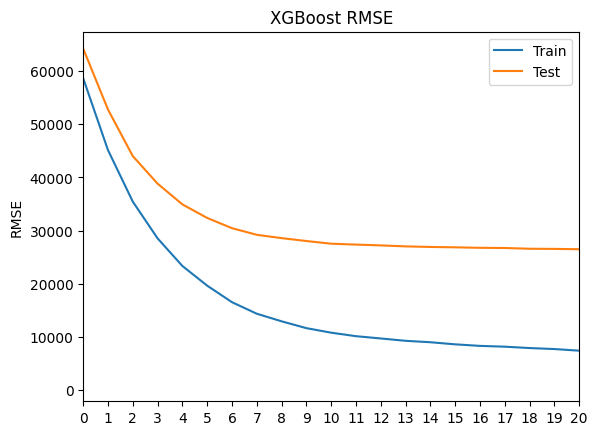

In [ ]:
xgbr = XGBRegressor(eval_metric="rmse")

# fit model no training data
eval_set = [(X_train, y_train), (X_test, y_test)]
xgbr.fit(X_train, y_train,
         eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = xgbr.predict(X_test)
# evaluate predictions
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")


results = xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.set_xticks(x_axis)
ax.set_xlim(0, 20)
ax.legend()

plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [44]:
xgbr.fit(X_encoded, y)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

Prepare df_test

In [ ]:
id_test = df_test["Id"]
df_test = df_test.drop(DROPPED_COL, axis=1)

for item in ORDINAL_MAPS:
    df_test[item["columns"]] = df_test[item["columns"]].map(
        lambda x: item["ordinalMap"].get(x, x))

In [ ]:
one_hot_encoded = encoder.transform(df_test[categorical_columns])

one_hot_X = pd.DataFrame(
    one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))


X_test_encoded = pd.concat([df_test.reset_index(
    drop=True), one_hot_X.reset_index(drop=True)], axis=1)

X_test_encoded = X_test_encoded.drop(categorical_columns, axis=1)

In [ ]:
df_submision = pd.DataFrame()
df_submision["Id"] = id_test
df_submision["SalePrice"] = xgb.predict(X_test_encoded)

In [ ]:
df_submision.to_csv("sub4_test.csv", index=False)